In [1]:
%%capture
!pip install pydna
!pip install pandas
!pip install --upgrade xlrd
!pip install constrain
!pip install venn

In [51]:
import IPython.core.display
import pathlib
import itertools
import numpy as np
import pandas as pd
import copy
import pydna
import pydna.editor
import pydna.primer
import pydna.dseqrecord
import pydna.amplify
import pydna.assembly
import pydna.gel
import pydna.ladders
from pydna.dseqrecord import Dseqrecord
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import venn

# 08_2_DESIGN_TargetedLibrary

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/08_2_DESIGN_TargetedLibrary.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repositoru like this: 

In [52]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


# 0. Intro

In this notebook we continue the workflow by analyzing the outcome from the ML in notebook [07_1_LEARN_DataAnalysis](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb). 

The purpose of this notebook is to: 
1. Create a smaller targeted library based on a machine learning prediction of the highest producing combination of genes from combinations seen in the figure below.


**Goal:**
We will be using ML to optimize our gene selection process by first focusing on the most highly represented genes. We will PCR amplify these parts, with a goal of 180 total parts. Our sampling strategy is based on the number of possible combinations, with the goal of achieving optimal sampling in the second round. Our ultimate goal is to quickly identify one of the best solutions within the large solution space by prioritizing 2 iterations and using ML for further analysis.


 
## Project overview
 
**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

#### Aim: To test the hypothesis through library design

Tasks
1. analyse seq data from first library construction
2. **Design 2nd Library**
    - investigate the outcome from the ML and select the top performing parts for a second round one-pot assembly.
3. **Build 2nd Library**
4. Phenotyping/Genotyping
5. Machine learning

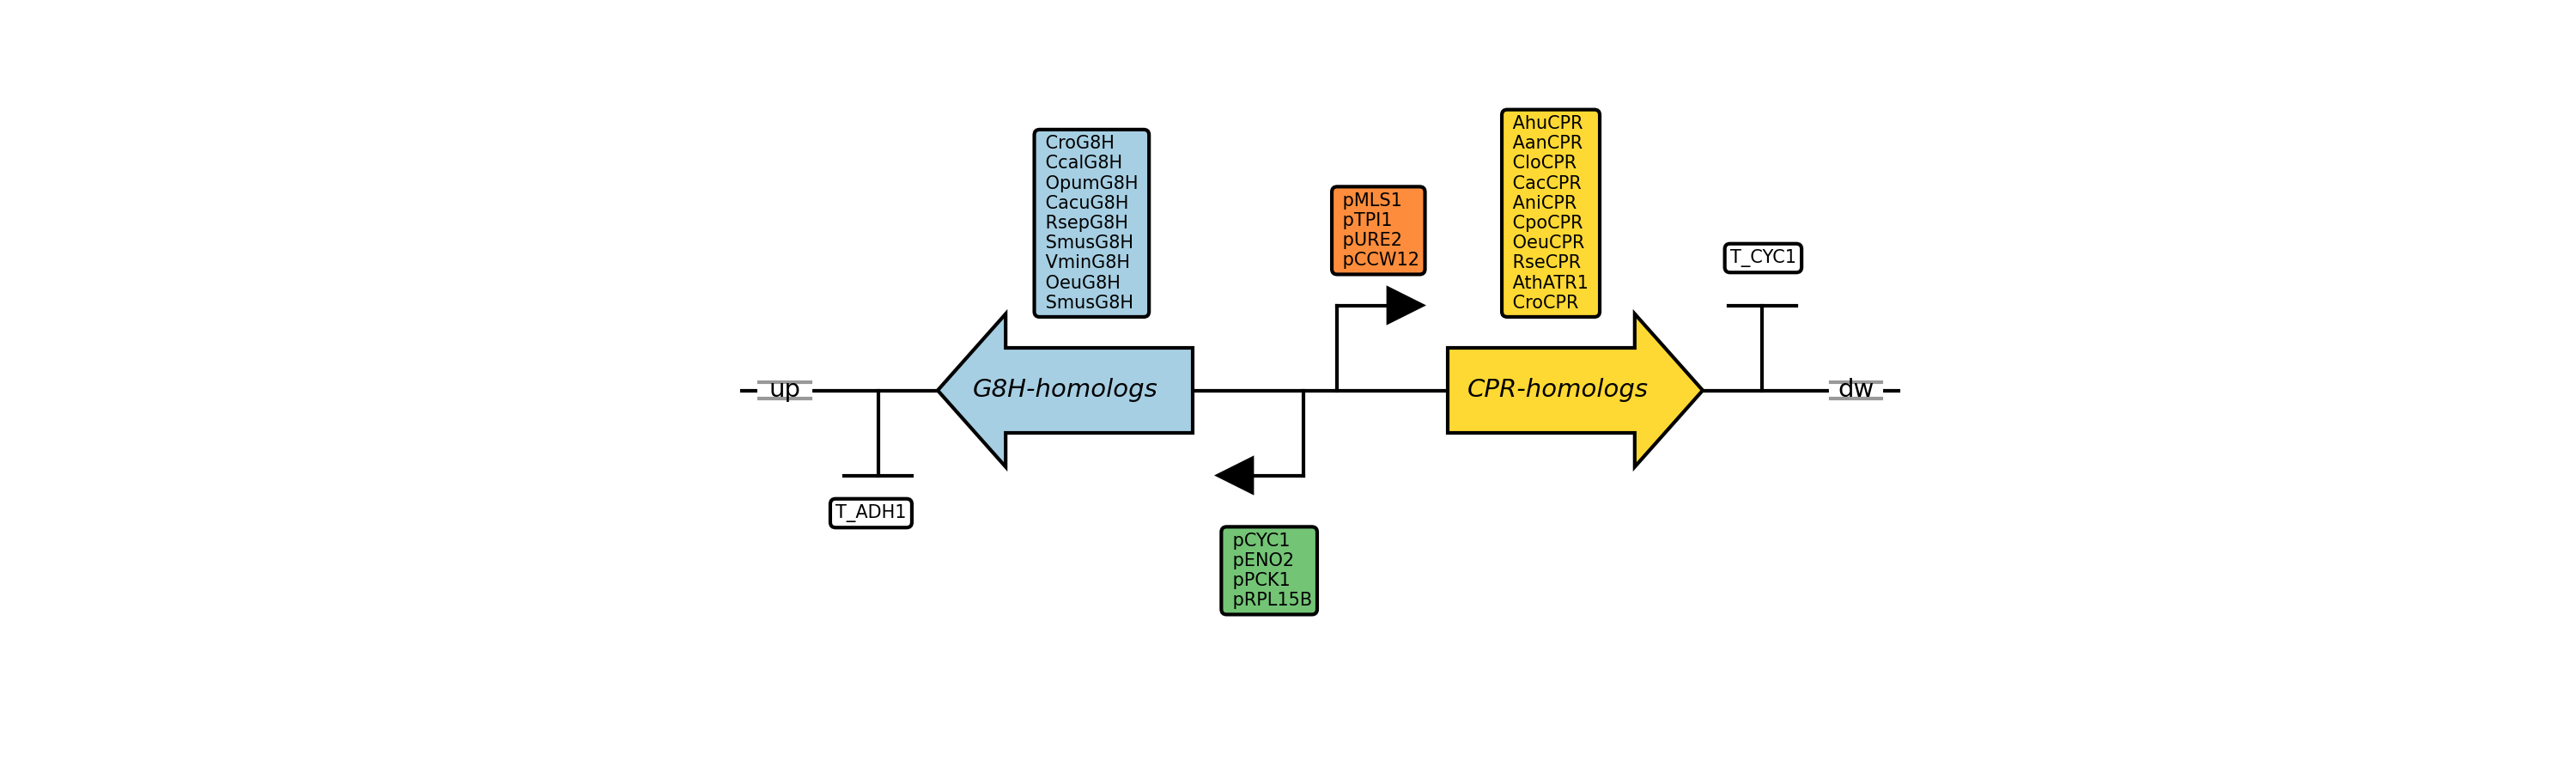

In [53]:
IPython.core.display.Image('ConStrain_on_google_colab/pictures/Genetic construct w dnaplotlib.png', width=2000)

The figure above illustrates the original library design.

**Machine learning pred:**
- In the following, the machine learning outcome can be found. 


# 1. Getting parts based on predictions

The first time we made a ML models we selected them based on RMSE. The models prediction can be seen below as 'df' while a second iteration called 'df2' were selected by MAE. The next paragraph compares the two models predictions based on which parts they select in the form of Venn diagrams seen in paragraph 3. 

In [54]:
#Get prediction data
# first ML prediction - RMSE
df = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/Predicted_strict_named_CMP_RMSE.csv')

# SECOND ML prediction - MAE
df2 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')

list_of_dfs = [df, df2]

In [55]:
df.head()

,G8H,pG8H,pCPR,CPR,predict
0,Rsep,ENO2,TPI1,Clo,255
1,Smus,ENO2,TPI1,Clo,246
2,Rsep,ENO2,TPI1,Ara,215
3,Smus,ENO2,TPI1,Rse,197
4,Smus,ENO2,TPI1,Aan,182


In [56]:
df2.head()

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989


### 1.1 Selecting parts from first ML modesl prediction and comparing with the second ML model predictions. 

In [57]:
from constrain.design.combinatorial_design import count_unique_parts

In [58]:
list_of_analysis = ['1st_ana', '2nd_ana']


So we want to have fewer than 180 and by trying different numbers we find that the Sum of parts jumps from 140 to 210. Therefore we set it to 140. 

In [59]:
for i in range(len(list_of_dfs)): 
    parts = count_unique_parts(list_of_dfs[i], 140 )
    print('\n')
    print(f"{i} : {list_of_analysis[i]}")
    for k,v in parts.items(): 
        print(k,v)



0 : 1st_ana
G8H ['Rsep', 'Smus', 'Oeu', 'Vmin', 'Cro']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12']
CPR ['Clo', 'Ara', 'Rse', 'Aan', 'Cro', 'Ani', 'Ahu']
Sum of parts 140
Predictions 20


1 : 2nd_ana
G8H ['Smus', 'Rsep', 'Oeu', 'Cro', 'Vmin']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12']
CPR ['Cro', 'Cac', 'Aan', 'Ara', 'Rse', 'Clo', 'Oeu']
Sum of parts 140
Predictions 38


By selecting the top parts that gives less than 180 combination, the first machine learning (ML) model chose a total of 140 parts from 20 predictions. This means that the ML model was able to identify 140 parts that were deemed to be the most promising or highest producing combinations out of 25 possible predictions. On the other hand, the second ML model chose 140 parts from a total of 26 predictions.

However, note that it is not possible to reproduce the results of these ML models with 100% accuracy due to the inherent stochasticity and variability in machine learning.

Below the differences will be displayed in which parts were seleceted by the different ML algorithms. 


### 1.2 Selecting colors

In [60]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8h_color= color_range_dict()['blue'][::3][::-1]
print(len(g8h_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [61]:
g8h_list_of_index = ["Cacu_G8H", "Opum_G8H","Cro_G8H","Vmin_G8H","Smus_G8H","Rsep_G8H","Oeu_G8H","Ccal_G8H"]
cpr_list_of_index = ["Cro_CPR", "Aan_CPR","Ara_CPR","Clo_CPR","Rse_CPR","Ahu_CPR","Ani_CPR","Cac_CPR","Oeu_CPR","Cpo_CPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]

In [62]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [63]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

# 3. Venn diagram - plotting differences between the ML predictions

In [64]:
column_names=['G8H','pG8H',	'pCPR',	'CPR']
max_combinations = 140

In [65]:
parts_1st_ml = count_unique_parts(df, max_combinations)
parts_2nd_ml = count_unique_parts(df2 ,max_combinations)

for k,v in parts_1st_ml.items(): 
    parts_1st_ml[k] = set(parts_1st_ml[k])
    
for k,v in parts_2nd_ml.items(): 
    parts_2nd_ml[k] = set(parts_2nd_ml[k])
parts_2nd_ml

{'G8H': {'Cro', 'Oeu', 'Rsep', 'Smus', 'Vmin'},
 'pG8H': {'CYC1', 'ENO2'},
 'pCPR': {'CCW12', 'TPI1'},
 'CPR': {'Aan', 'Ara', 'Cac', 'Clo', 'Cro', 'Oeu', 'Rse'},
 'Sum of parts': {'0', '1', '4'},
 'Predictions': {'3', '8'}}

In [66]:
parts_1st_ml['Sum of parts']

{'0', '1', '4'}

In [67]:
# remove sum of parts 
parts_1st_ml.pop('Sum of parts', None)
parts_2nd_ml.pop('Sum of parts', None)

{'0', '1', '4'}

In [68]:
#Remove predictions
parts_1st_ml.pop('Predictions', None)
parts_2nd_ml.pop('Predictions', None)

{'3', '8'}

In [69]:
from venn import venn
%matplotlib inline
venn_dicts = []

for k, v in parts_1st_ml.items(): 
    for k1, v1 in parts_2nd_ml.items():
        if k==k1:
            my_dict = {k+'_ML1':v, k1+'_ML2':v1}
            venn_dicts.append(my_dict)
            print(my_dict)
            #venn(my_dict)
            #venn_diagrams.append(venn(my_dict))

{'G8H_ML1': {'Rsep', 'Cro', 'Vmin', 'Oeu', 'Smus'}, 'G8H_ML2': {'Rsep', 'Cro', 'Vmin', 'Oeu', 'Smus'}}
{'pG8H_ML1': {'ENO2', 'CYC1'}, 'pG8H_ML2': {'ENO2', 'CYC1'}}
{'pCPR_ML1': {'TPI1', 'CCW12'}, 'pCPR_ML2': {'TPI1', 'CCW12'}}
{'CPR_ML1': {'Ara', 'Rse', 'Clo', 'Ahu', 'Cro', 'Aan', 'Ani'}, 'CPR_ML2': {'Ara', 'Rse', 'Clo', 'Cro', 'Oeu', 'Cac', 'Aan'}}


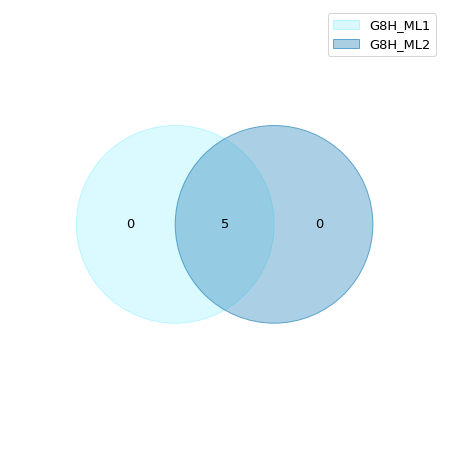

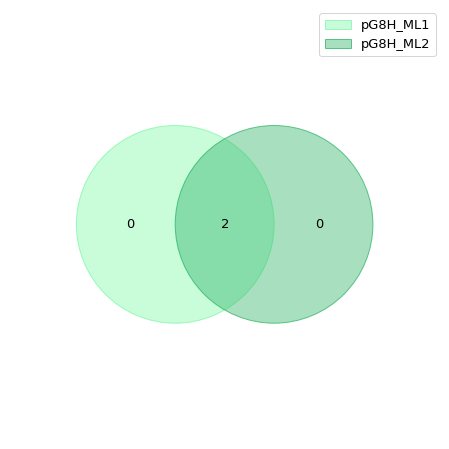

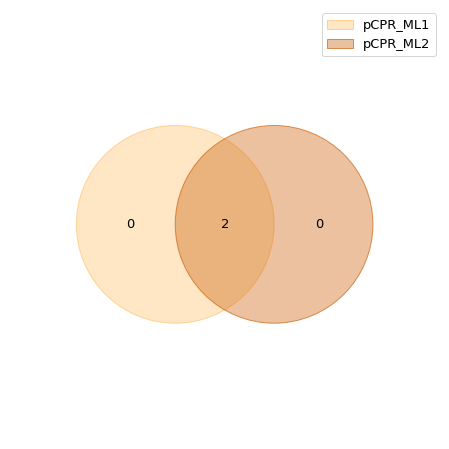

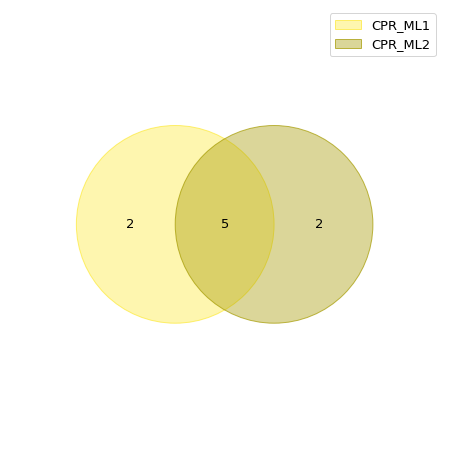

In [70]:
# G8H
venn(venn_dicts[0], cmap = [g8h_color[0], g8h_color[-1] ])
name = 'Venn_G8H'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# pG8H
venn(venn_dicts[1], cmap = [pg8h_color[0], pg8h_color[-1] ])
name = 'Venn_pG8H'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# pCPR
venn(venn_dicts[2], cmap = [pcpr_color[0], pcpr_color[-1] ])
name = 'Venn_pCPR'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# CPR
venn(venn_dicts[3], cmap = [cpr_color[1], cpr_color[-1] ])
name = 'Venn_CPR'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)

As evidenced by the Venn diagrams, the predictions generated by the first machine learning model are found to be similar to those produced by the second machine learning model, with the exception of the CPRs. Specifically, it was observed that five of the CPRs were consistent between the two models, while two were found to be dissimilar. These findings will be the subject of further analysis and discussion in the conclusion of this notebook.

# 4. Stacked barplot of top predicted combinations from the combinatorial library

In this next section, we will dive deeper into the top predicted gene combinations by utilizing a visualization technique we call a carpet plot. This type of plot is particularly useful for examining the relationship between multiple variables across a large number of samples. By creating a carpet plot of the top predicted gene combinations, we will be able to gain a more comprehensive understanding of the patterns and trends in the data, as well as identify any potential outliers or anomalies. Additionally, the carpet plot will allow us to easily compare the performance of different gene combinations, providing valuable insights for further experimentation and optimization. Overall, this analysis will provide a powerful tool for understanding the underlying mechanisms of the gene combinations and will help us to further improve the prediction of the highest producing combination of genes.

## DF1 (Firts ML model predictions)

In [71]:
from constrain.plotting.plotting import carpet_barplot

### 1. The best combinations for max 180 strains i.e 20 predictions - DF1 (first ml)

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/3328432634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['G8H'] = def_merged['G8H']+'_G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/3328432634.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['CPR'] = def_merged['CPR']+'_CPR'


4456
4456
4456


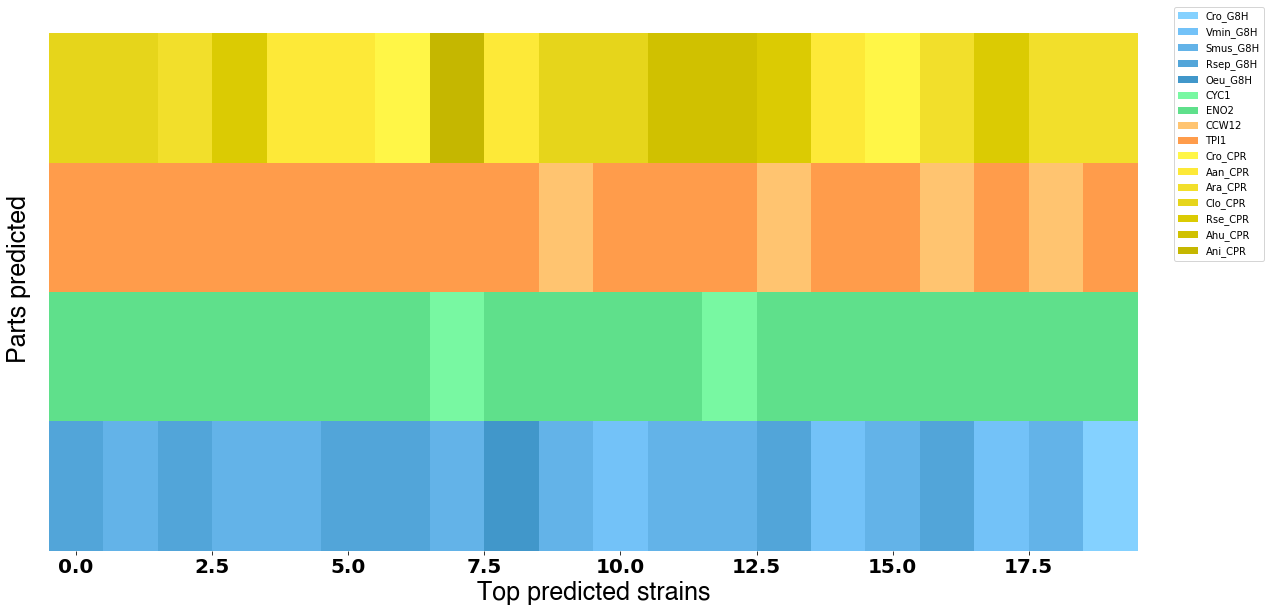

In [72]:
# take the columns we are interested in
def_merged = df[['G8H', 'pG8H','pCPR','CPR']]
def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index

list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

# make a df
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df_1 = pd.DataFrame(d)
tot_predictions = 20*4
df_35 = df_1[:tot_predictions]


# making a cross tab pd.dataframe
cross_tab_prop = pd.crosstab(index=df_35['Index'],
                             columns=df_35['Part'])
# get the right coloums
coloumns = list(cross_tab_prop.columns)
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR']


# fix columns
fixed_columns = []
for name in all_parts: 
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

# carpet plot
name = 'Best_combinations_predicted_by_the_ML_20_df1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### 2. Plotting best 100 combinations

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/4188081009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['G8H'] = def_merged['G8H']+'_G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/4188081009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['CPR'] = def_merged['CPR']+'_CPR'


4456
4456
4456


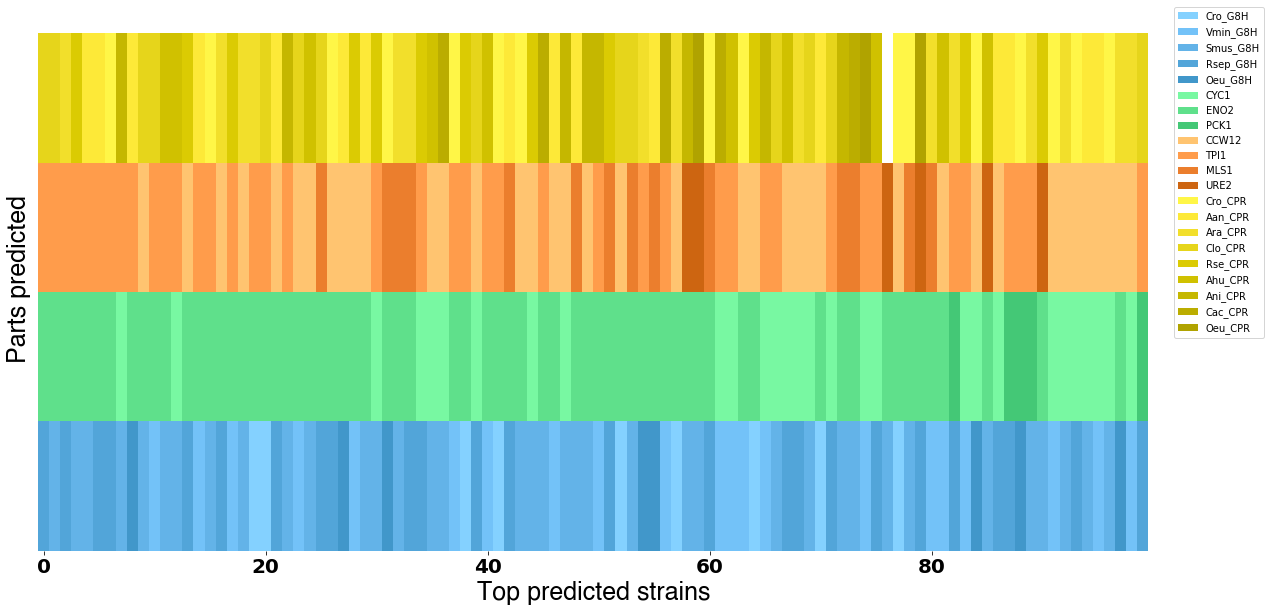

In [73]:
# take the columns we are interested in
def_merged = df[['G8H', 'pG8H','pCPR','CPR']]
def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index

list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

# make a df
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df_1 = pd.DataFrame(d)
tot_predictions = 100*4
df_100 = df_1[:tot_predictions]


# making a cross tab pd.dataframe
cross_tab_prop = pd.crosstab(index=df_100['Index'],
                             columns=df_100['Part'])
# get the right coloums
coloumns = list(cross_tab_prop.columns)
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR']


# fix columns
fixed_columns = []
for name in all_parts: 
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

# carpet plot
name = 'Best_combinations_predicted_by_the_ML_100_df1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

## DF2 (Second ML model predictions)

In [74]:
# take the columns we are interested in
def_merged = df2[['G8H', 'pG8H','pCPR','CPR']]
def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index
def_merged.head()

# get list of parts
list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

4484
4484
4484


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/897797702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['G8H'] = def_merged['G8H']+'_G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4374/897797702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['CPR'] = def_merged['CPR']+'_CPR'


### 1. The best combinations for max 180 strains i.e 26 predictions - DF2 (second ml)

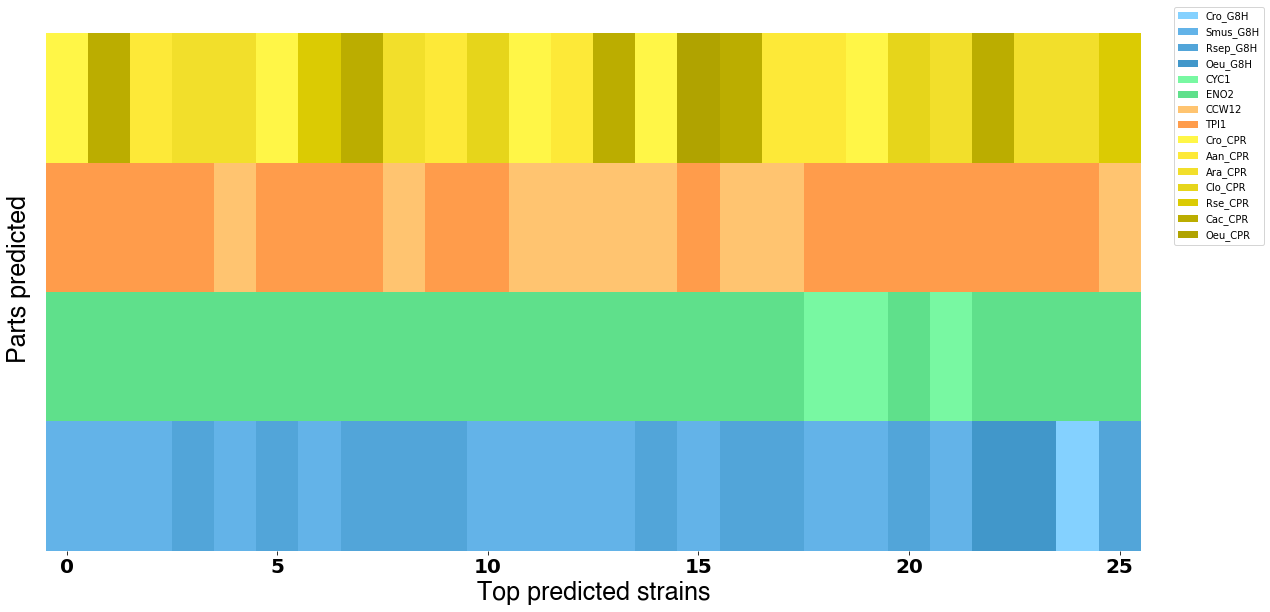

In [75]:
# Make a dataframe with top26 predictio s
tot_combinations_from_predictions = 26*4
df26 = df2[:tot_combinations_from_predictions]

# Make a crosstab df
cross_tab_prop = pd.crosstab(index=df26['Index'],
                             columns=df26['Part'])
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

# use the carpet plot function
name = 'Best_combinations_predicted_by_the_ML_26_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### 7. The best combinations for max 180 strains i.e 20 predictions - DF2 (second ml)

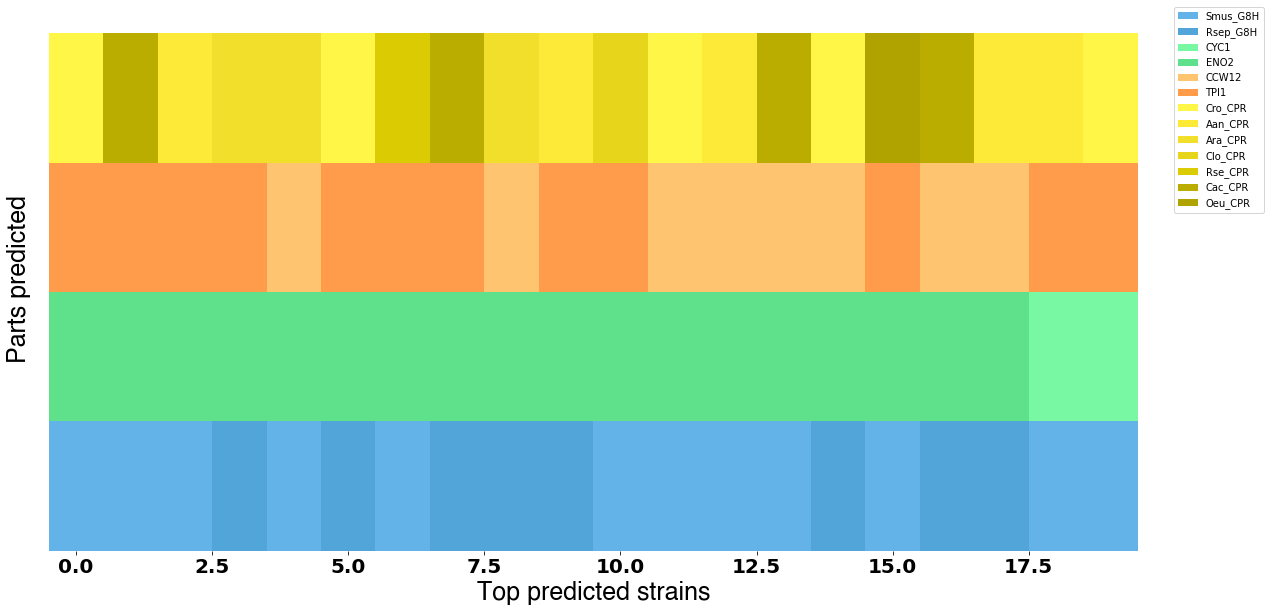

In [76]:
# Make a dataframe with top26 predictio s
tot_combinations_from_predictions = 20*4
df26 = df2[:tot_combinations_from_predictions]

# Make a crosstab df
cross_tab_prop = pd.crosstab(index=df26['Index'],
                             columns=df26['Part'])

# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

# use the carpet plot function
name = 'Best_combinations_predicted_by_the_ML_35_2'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### 2. Plotting the 100 highest performing predicted combinations

Slicing the dataframe

In [77]:
df100 = df2[:400]

In [78]:
# making a cross tab pd.dataframe
cross_tab_prop = pd.crosstab(index=df100['Index'],
                             columns=df100['Part'])
cross_tab_prop

Part,Aan_CPR,Ahu_CPR,Ani_CPR,Ara_CPR,CCW12,CYC1,Cac_CPR,Clo_CPR,Cpo_CPR,Cro_CPR,Cro_G8H,ENO2,MLS1,Oeu_CPR,Oeu_G8H,Opum_G8H,Rse_CPR,Rsep_G8H,Smus_G8H,TPI1,URE2,Vmin_G8H
Index,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
96,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
97,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [79]:
coloumns = list(cross_tab_prop.columns)
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR',
 'Cpo_CPR']

Check what names there are in the columns

In [80]:
fixed_columns = []
for name in all_parts: 
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

In [81]:
print(cross_tab_prop.columns)
cross_tab_prop

Index(['Opum_G8H', 'Cro_G8H', 'Vmin_G8H', 'Smus_G8H', 'Rsep_G8H', 'Oeu_G8H',
       'CYC1', 'ENO2', 'CCW12', 'TPI1', 'MLS1', 'URE2', 'Cro_CPR', 'Aan_CPR',
       'Ara_CPR', 'Clo_CPR', 'Rse_CPR', 'Ahu_CPR', 'Ani_CPR', 'Cac_CPR',
       'Oeu_CPR', 'Cpo_CPR'],
      dtype='object', name='Part')


Part,Opum_G8H,Cro_G8H,Vmin_G8H,Smus_G8H,Rsep_G8H,Oeu_G8H,CYC1,ENO2,CCW12,TPI1,MLS1,URE2,Cro_CPR,Aan_CPR,Ara_CPR,Clo_CPR,Rse_CPR,Ahu_CPR,Ani_CPR,Cac_CPR,Oeu_CPR,Cpo_CPR
Index,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
96,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
97,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


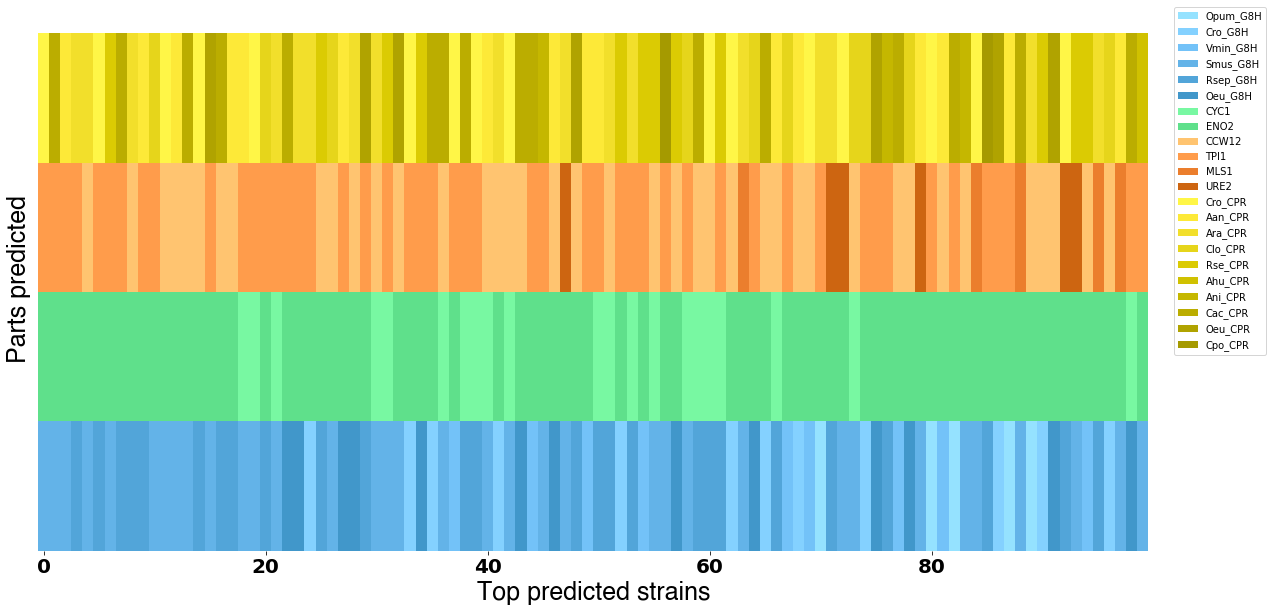

In [82]:
name = 'Best_combinations_predicted_by_the_ML_'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' )

### 3. Plotting the 200 highest performing predicted combinations

200


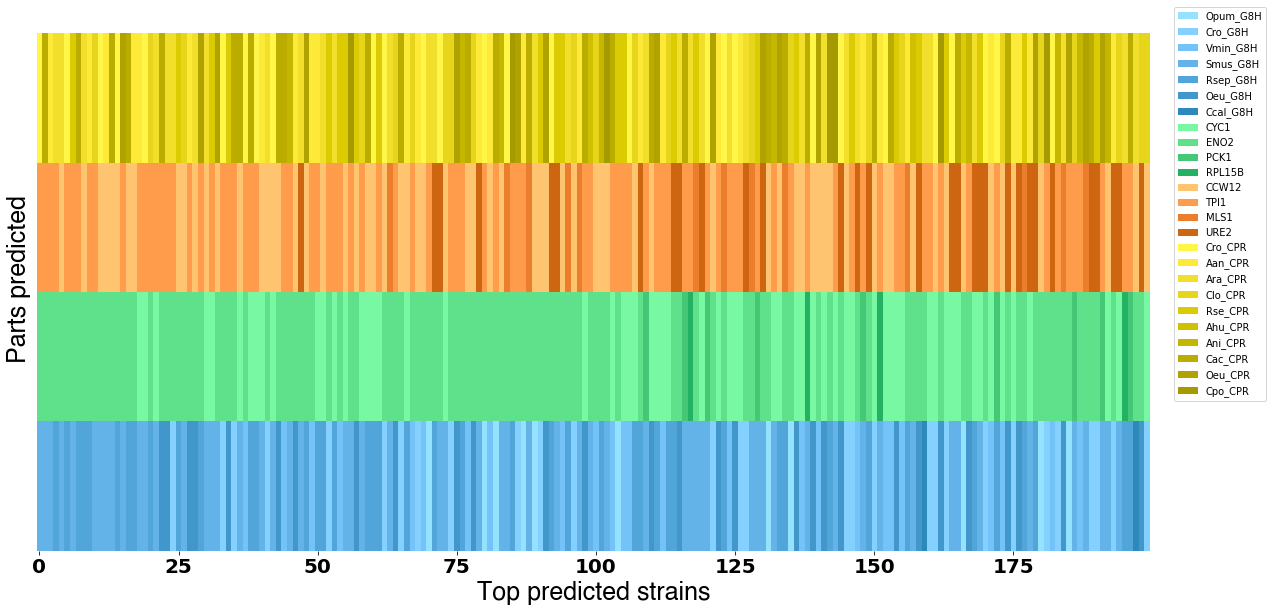

In [83]:
# slice df
df200 = df2[:800]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]


name = 'Best_combinations_predicted_by_the_ML_200_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### 4. Plotting all 1121 combinations sorted on highest predicted production

1121


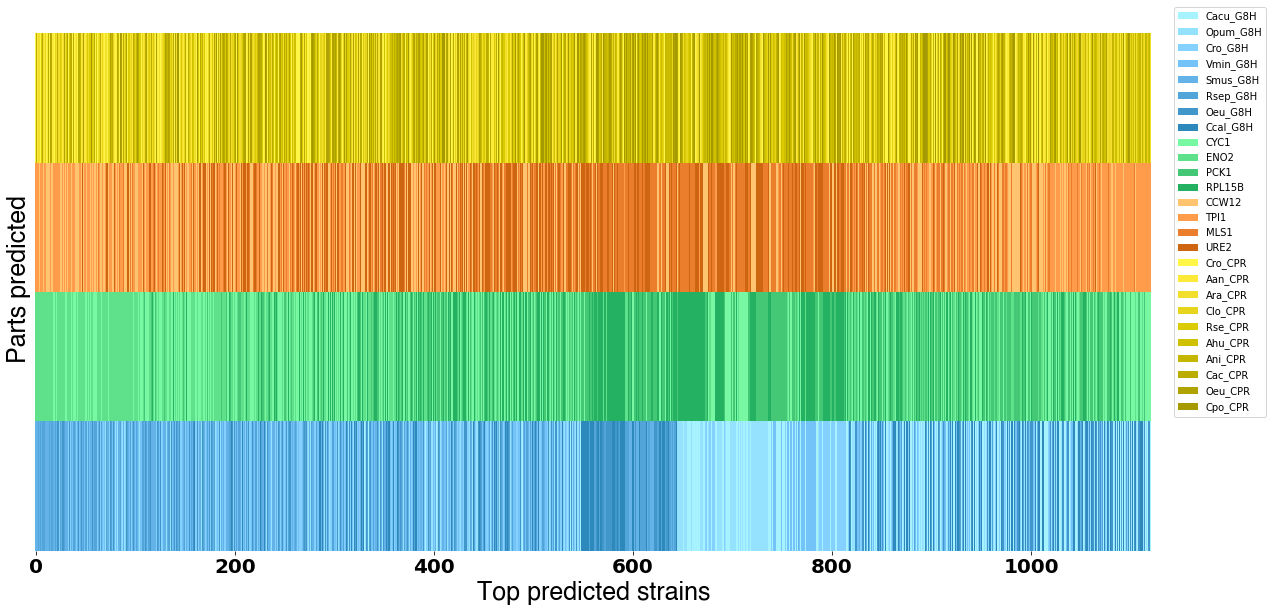

In [84]:
# slice df
df200 = df2[:]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])
print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]


name = 'Best_combinations_predicted_by_the_ML_all'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted'  )

# 5. Distribution of top strains sampled from notebook 7.

In [85]:
parts_sampled_strains = pd.read_csv('ConStrain_on_google_colab/data/07-lcms/processed/lcms_data/with_genotypes/genotypes_1st_round_w_wo_full_genotype.csv')
parts_sampled_strains = parts_sampled_strains[['Line_name','Amt_norm_x', 'G8H','pG8H', 'pCPR', 'CPR', ]]
parts_sampled_strains

,Line_name,Amt_norm_x,G8H,pG8H,pCPR,CPR
0,yp50_D03,245.034275,SmusG8H,pENO2,pTPI1,AraCPR
1,yp50_G03,156.327285,RsepG8H,pENO2,pTPI1,RseCPR
2,yp50_E05,144.340857,SmusG8H,pCYC1,pTPI1,CacCPR
3,yp51_A02,135.693498,OeuG8H,pENO2,pTPI1,CroCPR
4,yp50_A09,134.321746,VminG8H,pENO2,pTPI1,AraCPR
...,...,...,...,...,...,...
233,yp49_B09,0.000000,NaN,NaN,NaN,NaN
234,yp51_E06,0.000000,NaN,NaN,NaN,NaN
235,yp51_E03,0.000000,NaN,NaN,NaN,NaN
236,yp50_D10,0.000000,NaN,NaN,NaN,NaN


In [86]:
list_of_parts = []
parst_index = []

for index, row in parts_sampled_strains.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

952
952
952


In [87]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

In [88]:
df2 = df2.replace(np.nan, 'Not_fully_genotyped')

In [89]:
pd.set_option('display.max_columns', None)

In [90]:
cross_tab_prop = pd.crosstab(index=df2['Index'],
                             columns=df2['Part'])
cross_tab_prop

Part,AanCPR,AhuCPR,AniCPR,AraCPR,CacCPR,CacuG8H,CcalG8H,CloCPR,CpoCPR,CroCPR,CroG8H,Not_fully_genotyped,OeuCPR,OeuG8H,OpumG8H,RseCPR,RsepG8H,SmusG8H,VminG8H,pCCW12,pCYC1,pENO2,pMLS1,pPCK1,pRPL15B,pTPI1,pURE2
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
235,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
coloumns = list(cross_tab_prop.columns)

Have to make a new colorDict since the names in this data is different

In [92]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["pCYC1", "pENO2","pPCK1","pRPL15B"]
pcpr_list_of_index = ["pCCW12", "pTPI1","pMLS1","pURE2"]
NaN_list_of_index = ["Not_fully_genotyped"]

all_parts = g8h_list_of_index +cpr_list_of_index+ pg8h_list_of_index+pcpr_list_of_index+ NaN_list_of_index

In [93]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [95]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)
colorDict

{'CacuG8H': '#a6f3ff',
 'OpumG8H': '#95e2ff',
 'CroG8H': '#84d1ff',
 'VminG8H': '#73c2f8',
 'SmusG8H': '#63b3e8',
 'RsepG8H': '#52a5d9',
 'OeuG8H': '#4197ca',
 'CcalG8H': '#2d89bc',
 'pCYC1': '#78f8a2',
 'pENO2': '#5fe08b',
 'pPCK1': '#44c876',
 'pRPL15B': '#24b161',
 'pCCW12': '#ffc470',
 'pTPI1': '#ff9c4b',
 'pMLS1': '#eb7e2d',
 'pURE2': '#cd6511',
 'CroCPR': '#fff647',
 'AanCPR': '#fde938',
 'AraCPR': '#f2df2b',
 'CloCPR': '#e6d51b',
 'RseCPR': '#dbcb03',
 'AhuCPR': '#d0c100',
 'AniCPR': '#c5b700',
 'CacCPR': '#bbad00',
 'OeuCPR': '#b0a300',
 'CpoCPR': '#a59a00'}

Making the parts appear in the correct order 

In [96]:
right_order = ['CacuG8H',
 'OpumG8H',
 'CroG8H',
 'VminG8H',
 'SmusG8H',
 'RsepG8H',
 'OeuG8H',
 'CcalG8H',
 'pCYC1',
 'pENO2',
 'pPCK1',
 'pRPL15B',
 'pCCW12',
 'pTPI1',
 'pMLS1',
 'pURE2',    
 'CroCPR',
 'AanCPR',
 'AraCPR',
 'CloCPR',
 'RseCPR',
 'AhuCPR',
 'AniCPR',
 'CacCPR',
 'OeuCPR',
 'CpoCPR', 
 'Not_fully_genotyped']

In [97]:
fixed_columns = []
for name in right_order: 
    if name in coloumns: 
        fixed_columns.append(name)
cross_tab_prop = cross_tab_prop[fixed_columns]

Add a white color to the not_fully_genotype colorDict

In [98]:
colorDict['Not_fully_genotyped'] = '#FFFFFF'

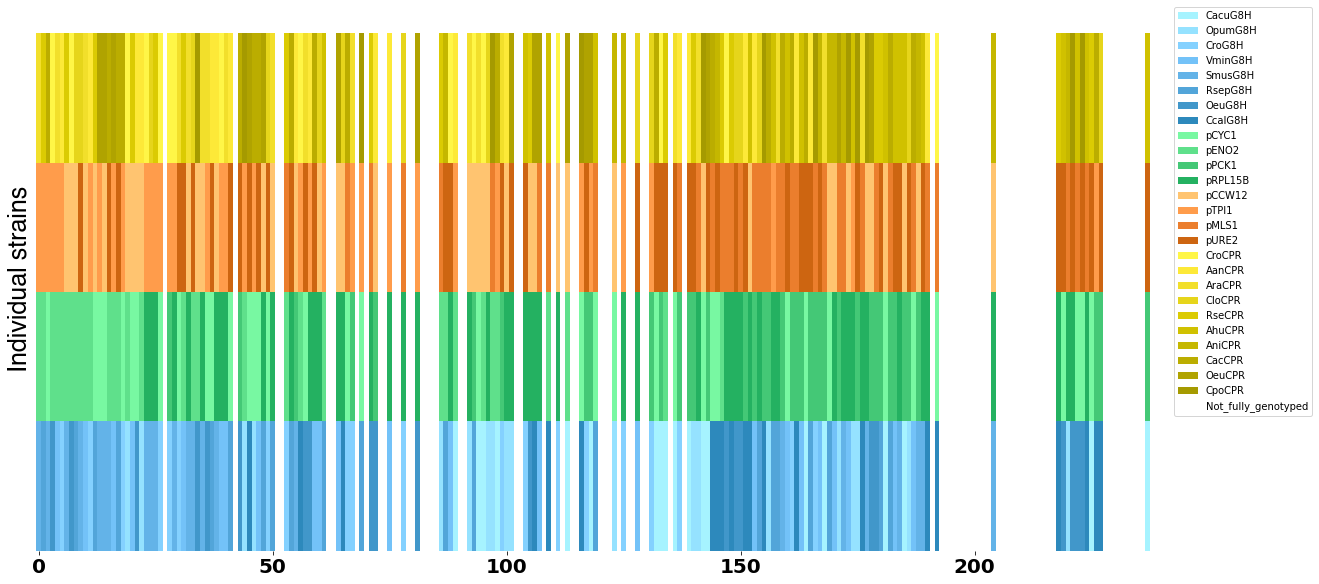

In [99]:
name = 'Carpet_plot_All_genotypes_from_the_first_library_WHITE'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True ,
               path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, 
               xlabel ='' , 
               ylabel = 'Individual strains' )

From this outcome, the parts encountered in the first 26 predictions, resulting in 140 combinations and 35 transformations. 

# 6. ML discussion/conclusion

**ML distribution:**
In this section, we examined the distribution of the top predicted gene combinations in the form of a carpet plot. The most represented genes in the plot were the high-low and constitutive high promoters, as determined by objective biological criteria. To select which genes to proceed with, we utilized a sampling strategy where we took a set number of parts, adding more as new genes were represented. The goal was to reach a total of 180 parts, while also considering any potential limitations such as the number of plates available. We then created a quadrature plot to visualize the distribution of parts across the different categories.

Our sampling strategy was based on the principles of optimal sampling, where we aimed to sample the total number of possible combinations. This was in contrast to our previous strategy, which did not fully utilize the capacity of the system. In this case, we aimed to make the most efficient use of the resources available, while also attempting to identify the best possible combination within the limited time and resources. Additionally, we also had the option to apply machine learning techniques after the second iteration to evaluate the change in mean absolute error. Furthermore, it should be noted that promoters are quite stable, and we should only have two of each, which are the highly expressed ones, whereas CPR was not very stable, with 7 different ones within the first 20 predictions. This suggests that CPR is more promisciuos or does not increase the final titer considarably compared to G8H. This makes sense the strain contains a native CPR that could contribube with reducing power and hence limit how much a new CPR contribute. 

**Conclusion**




It was found that 140 strains (5x2x2x7)was suitable for the pupose.
- From the predictions, the following genes have been selected: 
    - Smus, Vmin, Cro, Rsep, Oeu
    - pCYC1, pENO2
    - Clo, Ara, Rse, Aan, Cro, Ani, Ahu
    - pTPI1, pCCW12

**Experiment:**
- To perform this experiment, a total of 35 (5*7) transformation should be performed 
- To perform this, each gene has several different overhangs and these are pooled together. All promoters are also pooled together. UP, DW and cTRP1 is pooled together. Then the correct mixes should be performed. 

The previous experiments were made in [05_1_BUILD_CombinatorialLibrary_AllStrains](../colab_notebooks/05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb), and the next step in the process is to make the targeted library. Which will be done in notebook [09_2_BUILD_CombinatorialLibrary](./colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb).